# LSTM-MULTIVARIATE V2

Changes from LSTM-MULTIVARIATE.ipynb:

-Multivariates input, but predicting only 'Close' price.

-Added 'tomorrow's price prediction' feature

In [1]:
# IMPORTS
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
from math import sqrt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from datetime import date, timedelta, datetime
import pandas_datareader as webreader
import datetime as dt
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

In [2]:
#Build and train the model
def fit_model(X_train,Y_train,hl,lr,batch,epochs):
    #X_train = []
    #Y_train = []
    #X_val = []
    #Y_val = []
  
    """
    # Loop for training data
    for i in range(timesteps,train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)
  
    # Loop for val data
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val,Y_val = np.array(X_val),np.array(Y_val)
    """
    # Adding Layers to the model
    model = Sequential()
    model.add(LSTM(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                   activation = 'relu'))
    for i in range(len(hl)-1):        
        model.add(LSTM(hl[i],activation = 'relu',return_sequences = True))
    model.add(LSTM(hl[-1],activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = tf.keras.optimizers.Adam(lr), loss = 'mean_squared_error')
    print(model.summary())
  
    # Training the data
    early_stop = EarlyStopping(monitor='loss', patience=50, verbose=1)
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,verbose = 1,
                        shuffle = False, callbacks=early_stop)
    model.reset_states()
    return model, history.history['loss']
#, history.history['val_loss']

In [3]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
    X_test = []
    Y_test = []
    # Loop for testing data
    for i in range(timesteps,test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
    print(X_test.shape,Y_test.shape)
  
    # Prediction Time !!!!
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test,Y_hat)
    rmse = sqrt(mse)
    r = r2_score(Y_test,Y_hat)
    return mse, rmse, r, Y_test, Y_hat

In [4]:
# COMMON
symbol = 'SPY'
stockname = 'S&P 500 ETF Trust'
timeWindowInYears = 20
timeWindowInDays = timeWindowInYears * 365
testDays = 100
FEATURES = ['Close','High','Low', 'Open', 'Adj Close']

In [5]:
# PULL DATASET FROM YAHOO FINANCIALS
today = date.today()
date_today = today.strftime("%Y-%m-%d")
date_start = pd.Timestamp('today') - timedelta(days=timeWindowInDays)
df = webreader.DataReader(symbol, data_source='yahoo', start=date_start, end=date_today)
df.head()

High         Low        Open       Close      Volume  \
Date                                                                     
2002-02-11  111.639999  109.820000  110.050003  111.440002  18792400.0   
2002-02-12  111.709999  110.029999  110.959999  111.089996  13942500.0   
2002-02-13  112.540001  111.349998  111.480003  112.269997  16781100.0   
2002-02-14  112.970001  111.589996  112.510002  112.059998  20453800.0   
2002-02-15  112.239998  110.709999  112.150002  110.889999  18366800.0   

            Adj Close  
Date                   
2002-02-11  75.953781  
2002-02-12  75.715210  
2002-02-13  76.519470  
2002-02-14  76.376350  
2002-02-15  75.578918

In [6]:
# calculate correlation
df.corr()['Close']

High         0.999883
Low          0.999896
Open         0.999834
Close        1.000000
Volume      -0.250821
Adj Close    0.998567
Name: Close, dtype: float64

In [7]:
# select relevant features
# Extracting the series
dfWithRelevantFeatures = df[FEATURES] # Picking the series with high correlation
print(dfWithRelevantFeatures.head())

                 Close        High         Low        Open  Adj Close
Date                                                                 
2002-02-11  111.440002  111.639999  109.820000  110.050003  75.953781
2002-02-12  111.089996  111.709999  110.029999  110.959999  75.715210
2002-02-13  112.269997  112.540001  111.349998  111.480003  76.519470
2002-02-14  112.059998  112.970001  111.589996  112.510002  76.376350
2002-02-15  110.889999  112.239998  110.709999  112.150002  75.578918


IndexError: index 5 is out of bounds for axis 0 with size 5

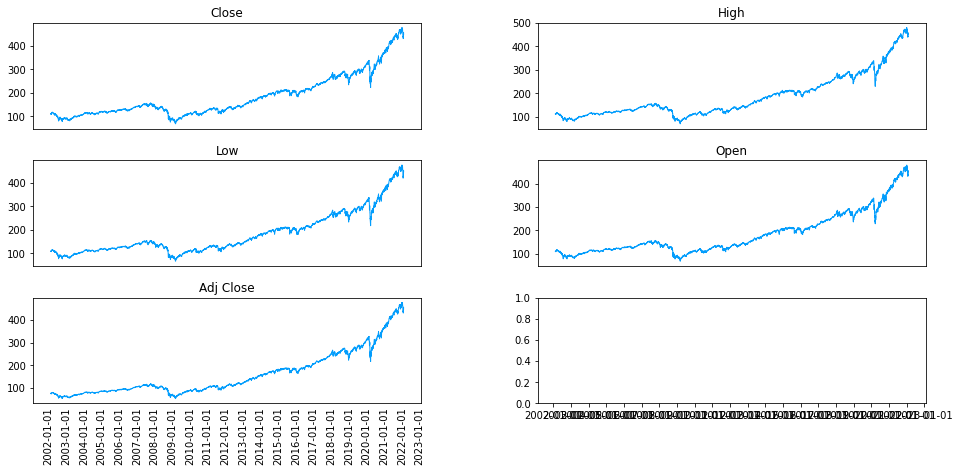

In [8]:
# Plot each column
register_matplotlib_converters()
nrows = 3
ncols = int(round(dfWithRelevantFeatures.shape[1] / nrows, 0))
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(16, 7))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
x = dfWithRelevantFeatures.index
columns = dfWithRelevantFeatures.columns
f = 0
for i in range(nrows):
    for j in range(ncols):
        ax[i, j].xaxis.set_major_locator(mdates.YearLocator())
        assetname = columns[f]
        y = dfWithRelevantFeatures[assetname]
        f += 1
        ax[i, j].plot(x, y, color='#039dfc', label=stockname, linewidth=1.0)
        ax[i, j].set_title(assetname)
        ax[i, j].tick_params(axis="x", rotation=90, labelsize=10, length=0)   

In [ ]:
"""
# Train Val Test Split
train_start = dt.date(2010,1,1)
train_end = dt.date(2019,12,31)
train_data = dfWithRelevantFeatures.loc[train_start:train_end]

val_start = dt.date(2020,1,1)
val_end = dt.date(2020,12,31)
val_data = dfWithRelevantFeatures.loc[val_start:val_end]

test_start = dt.date(2021,1,1)
test_end = dt.date(2021,12,31)
test_data = dfWithRelevantFeatures.loc[test_start:test_end]

print(train_data.shape,val_data.shape,test_data.shape)
"""

In [ ]:
"""
# Calculate the number of rows in the data
nrows_train = train_data.shape[0]
np_data_unscaled_train = np.array(train_data)
np_data_unscaled_train = np.reshape(np_data_unscaled_train, (nrows_train, -1))
print(np_data_unscaled_train.shape)

nrows_val = val_data.shape[0]
np_data_unscaled_val = np.array(val_data)
np_data_unscaled_val = np.reshape(np_data_unscaled_val, (nrows_val, -1))
print(np_data_unscaled_val.shape)

nrows_test = test_data.shape[0]
np_data_unscaled_test = np.array(test_data)
np_data_unscaled_test = np.reshape(np_data_unscaled_test, (nrows_test, -1))
print(np_data_unscaled_test.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = RobustScaler()
np_data_train = scaler.fit_transform(np_data_unscaled_train)
np_data_val = scaler.fit_transform(np_data_unscaled_val)
np_data_test = scaler.fit_transform(np_data_unscaled_test)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = RobustScaler()
df_Close = pd.DataFrame(dfWithRelevantFeatures['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)
"""

In [9]:
# Calculate the number of rows in the data
nrows = dfWithRelevantFeatures.shape[0]
np_data_unscaled = np.array(dfWithRelevantFeatures)
np_data_unscaled = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data_unscaled.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = RobustScaler()
np_data = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = RobustScaler()
df_Close = pd.DataFrame(dfWithRelevantFeatures['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(5032, 5)


In [10]:
# MODEL TRAINING PARAMS
timesteps = 60
hl = [40,35]
lr = 0.001
batch_size = 64
num_epochs = 1

In [11]:
# Split the training data into x_train and y_train data sets
# Get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_data.shape[0] * 0.9) 

# Create the training data
train_data = np_data[0:train_data_len, :]
x_train, y_train = [], []
# The RNN needs data with the format of [samples, time steps, features].
# Here, we create N samples, 100 time steps per sample, and 2 features
for i in range(timesteps, train_data_len):
    x_train.append(train_data[i-timesteps:i,:]) #contains 100 values 0-100 * columsn
    y_train.append(train_data[i, 0]) #contains the prediction values for validation
    
# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Create the test data
test_data = np_data[train_data_len - timesteps:, :]

# Split the test data into x_test and y_test
x_test, y_test = [], []
test_data_len = test_data.shape[0]
for i in range(timesteps, test_data_len):
    x_test.append(test_data[i-timesteps:i,:]) #contains 100 values 0-100 * columsn
    y_test.append(test_data[i, 0]) #contains the prediction values for validation
# Convert the x_train and y_train to numpy arrays
x_test, y_test = np.array(x_test), np.array(y_test)

# Convert the x_train and y_train to numpy arrays
x_test = np.array(x_test); y_test = np.array(y_test)
    
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(4469, 60, 5) (4469,)
(503, 60, 5) (503,)


In [12]:
model,train_error = fit_model(x_train,y_train,hl,lr,batch_size,num_epochs)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 5)             220       
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 40)            7360      
_________________________________________________________________
lstm_2 (LSTM)                (None, 35)                10640     
_________________________________________________________________
dense (Dense)                (None, 1)                 36        
Total params: 18,256
Trainable params: 18,256
Non-trainable params: 0
_________________________________________________________________
None
70/70 [==============================] - 5s 44ms/step - loss: 0.0509


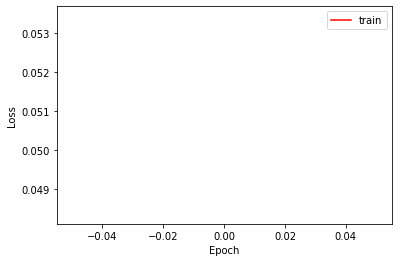

In [13]:
plt.plot(train_error,c = 'r')
#plt.plot(val_error,c = 'b')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train','val'],loc = 'upper right')
plt.show()

In [14]:
"""
mse, rmse, r2_value,true,predicted = evaluate_model(model,np_data_test,timesteps)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))

print(predicted.shape)

plt.plot(true,c = 'r')
plt.plot(predicted,c = 'y')
plt.xlabel('Day')
plt.ylabel('Price')
plt.title('Stock Prediction Graph using Multivariate-LSTM model')
plt.legend(['Actual','Predicted'],loc = 'lower right')
plt.show()

"""
# Get the predicted values
predictions = model.predict(x_test)

mse = mean_squared_error(y_test,predictions)
rmse = sqrt(mse)
r2_value = r2_score(y_test,predictions)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test, predictions)/ y_test))) * 100
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test, predictions)/ y_test)) ) * 100
print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')


MSE = 0.29231172567272495
RMSE = 0.540658603624066
R-Squared Score = 0.06211498067793464
Mean Absolute Percentage Error (MAPE): 27.84 %
Median Absolute Percentage Error (MDAPE): 27.11 %


In [15]:
print(predictions.shape)

(503, 1)


(503, 6)


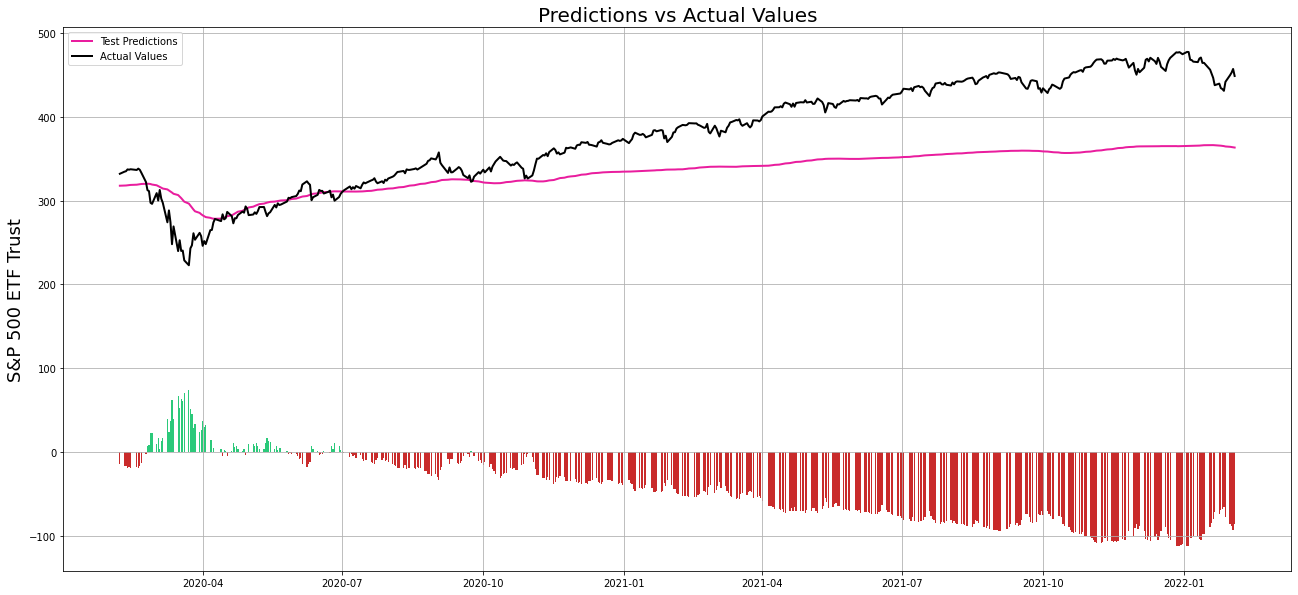

In [16]:
# Indexing Batches
train_df = dfWithRelevantFeatures.sort_values(by=['Date']).copy()

# We safe a copy of the dates index, before we need to reset it to numbers
date_index = train_df.index

# Get the predicted values
pred_unscaled = scaler_pred.inverse_transform(predictions)

# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=5000)

# Add the date column
data_filtered_sub = dfWithRelevantFeatures.copy()
data_filtered_sub['Date'] = date_index

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
print(valid.shape)
valid.insert(1, "Prediction", pred_unscaled.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Close"], True)

# Zoom in to a closer timeframe

valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.ylabel(stockname, fontsize=18)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

In [253]:
# Get fresh data until today and create a new dataframe with only the price data
date_start = pd.Timestamp('today') - timedelta(days=200)
new_df = webreader.DataReader(symbol, data_source='yahoo', start=date_start, end=date_today)
d = pd.to_datetime(new_df.index)
new_df['Month'] = d.strftime("%m") 
new_df['Year'] = d.strftime("%Y") 
new_df = new_df.filter(FEATURES)

# Get the last 100 day closing price values and scale the data to be values between 0 and 1
last_100_days = new_df[-100:].values
last_100_days_scaled = scaler.transform(last_100_days)

# Create an empty list and Append past 100 days
X_test_new = []
X_test_new.append(last_100_days_scaled)

# Convert the X_test data set to a numpy array and reshape the data
pred_price_scaled = model.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled)

# Print last price and predicted price for the next day
price_today = round(new_df['Close'][-1], 2)
predicted_price = round(pred_price_unscaled.ravel()[0], 2)
percent = round(100 - (predicted_price * 100)/price_today, 2)

a = '+'
if percent > 0:
    a = '-'

print('The close price for ' + stockname + ' at ' + str(today) + ' was: ' + str(price_today))
print('The predicted close price is: ' + str(pred_price_unscaled) + ' (' + a + str(percent) + '%)')

The close price for S&P 500 ETF Trust at 2022-02-02 was: 456.28
The predicted close price is: [[441.50977]] (-3.24%)
